In [1]:
from src.utils.utils import get_algo_by_name, get_env_by_name
from src.utils.save_results import get_task_name, get_metrics_information, get_results_file_name
import numpy as np
import time
import os
from datetime import date
from tqdm import tqdm
from tqdm.notebook import trange, tqdm
today = date.today()
import matplotlib.pyplot as plt
# import seaborn as sns; sns.set()

def do_single_experiment(rd, settings):
    env = get_env_by_name(settings)
    env.set()
    agent = get_algo_by_name(settings)
    agent.set_environment(env)
    metrics = agent.iterate_learning()
    return metrics

In [2]:
nb_rds = 20
max_rounds = 1000
nb_levels = 2

def do_paradox_experiment(nb_childs):

    exp3_regrets = np.zeros((nb_rds, int(max_rounds/100)))
    exp3_rewards = np.zeros((nb_rds, int(max_rounds/100)))
    new_regrets = np.zeros((nb_rds, int(max_rounds/100)))
    new_rewards = np.zeros((nb_rds, int(max_rounds/100)))
    nexp3_regrets = np.zeros((nb_rds, int(max_rounds/100)))
    nexp3_rewards = np.zeros((nb_rds, int(max_rounds/100)))
    ntsallis_regrets = np.zeros((nb_rds, int(max_rounds/100)))
    ntsallis_rewards = np.zeros((nb_rds, int(max_rounds/100)))

    for rd in range(nb_rds):
        settings = {
            'rd': rd,
            'max_rounds': max_rounds,
            'nb_leaves_per_class': nb_childs,
            'nb_levels': nb_levels,
            'env': 'paradox',
            'algo': 'exp3',
        }
        metrics = do_single_experiment(rd, settings)
        rounds = metrics['round']
        exp3_regrets[rd] = metrics['regret']
        exp3_rewards[rd] = metrics['reward']

        settings['algo'] = 'new'
        metrics = do_single_experiment(rd, settings)
        rounds = metrics['round']
        new_regrets[rd] = metrics['regret']
        new_rewards[rd] = metrics['reward']
        
        settings['algo'] = 'nexp3'
        metrics = do_single_experiment(rd, settings)
        rounds = metrics['round']
        nexp3_regrets[rd] = metrics['regret']
        nexp3_rewards[rd] = metrics['reward']

        settings['algo'] = 'ntsallis'
        metrics = do_single_experiment(rd, settings)
        rounds = metrics['round']
        ntsallis_regrets[rd] = metrics['regret']
        ntsallis_rewards[rd] = metrics['reward']

    # EXP3
    exp3_rgrt_std = np.std(exp3_regrets, axis=0)
    exp3_rwd_std = np.std(exp3_rewards, axis=0)
    exp3_regret = np.mean(exp3_regrets, axis=0)
    exp3_reward = np.mean(exp3_rewards, axis=0)
    
    exp3_result = (exp3_regret, exp3_rgrt_std, exp3_reward, exp3_rwd_std)

    # NEW
    new_rgrt_std = np.std(new_regrets, axis=0)
    new_rwd_std = np.std(new_rewards, axis=0)
    new_regret = np.mean(new_regrets, axis=0) 
    new_reward = np.mean(new_rewards, axis=0)
    
    new_result = (new_regret, new_rgrt_std, new_reward, new_rwd_std)

    # NEXP3
    nexp3_rgrt_std = np.std(nexp3_regrets, axis=0)
    nexp3_rwd_std = np.std(nexp3_rewards, axis=0)
    nexp3_regret = np.mean(nexp3_regrets, axis=0) 
    nexp3_reward = np.mean(nexp3_rewards, axis=0)
    
    nexp3_result = (nexp3_regret, nexp3_rgrt_std, nexp3_reward, nexp3_rwd_std)

    # NTSALLIS
    ntsallis_rgrt_std = np.std(ntsallis_regrets, axis=0)
    ntsallis_rwd_std = np.std(ntsallis_rewards, axis=0)
    ntsallis_regret = np.mean(ntsallis_regrets, axis=0) 
    ntsallis_reward = np.mean(ntsallis_rewards, axis=0)
    
    ntsallis_result = (ntsallis_regret, ntsallis_rgrt_std, ntsallis_reward, ntsallis_rwd_std)
    
    return (exp3_result, new_result, nexp3_result, ntsallis_result, 
            list(np.array(exp3_regrets)[:,-1]), list(np.array(new_regrets)[:,-1]), list(np.array(nexp3_regrets)[:,-1]), list(np.array(ntsallis_regrets)[:,-1]))

In [3]:
nb_childs = [2, 5, 10, 50]
res_new = []
res_nexp3 = []
res_exp3 = []
res_ntsallis = []
res=[]
labels=[]
exp3_results = []
nexp3_results = []
new_results = []
ntsallis_results = []

for nb_child in tqdm(nb_childs):
    a,b,c,d,e,f,g,h = do_paradox_experiment(nb_child)
    res_exp3.append(list(e))
    res_new.append(f)
    res_nexp3.append(g)
    res_ntsallis.append(h)
    res.append(e)
    res.append(f)
    res.append(g)
    res.append(h)
    labels.append('EXP3 - N {}'.format(nb_child))
    labels.append('NEW - N {}'.format(nb_child))
    labels.append('NEXP3 - N {}'.format(nb_child))
    labels.append('NTSALLIS-INF - N {}'.format(nb_child))
    exp3_results.append(a)
    new_results.append(b)
    nexp3_results.append(c)
    ntsallis_results.append(d)

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 10807.55it/s]
/Users/a.cablant/Documents/GitHub/Nested-Bandits/src/algorithms/ntsallis.py:81: RuntimeWarning: divide by zero encountered in divide
  return 2 * np.sum(np.sqrt(p) - np.sqrt(q)) - np.sum((p-q)/np.sqrt(p))
100%|██████████| 1000/1000 [00:32<00:00, 30.48it/s]


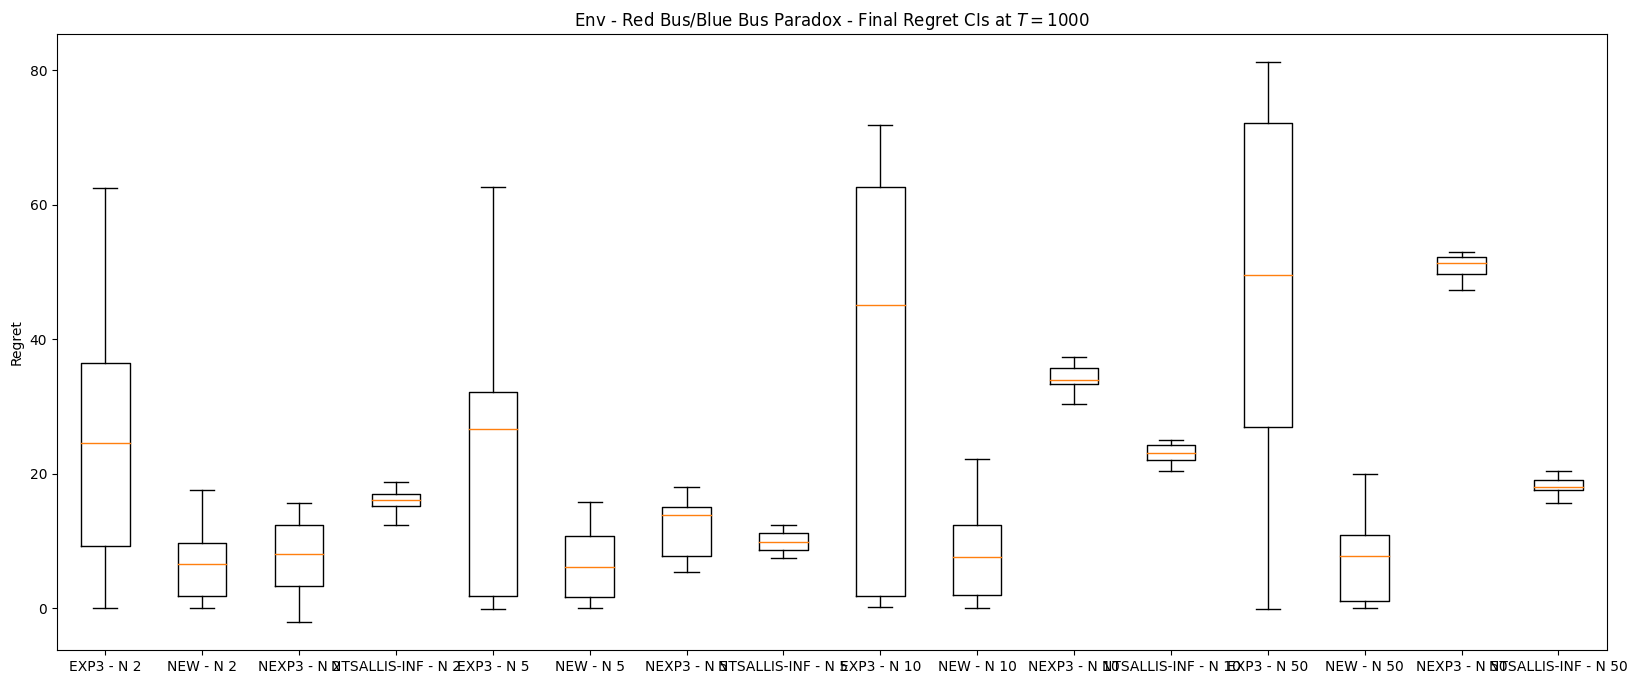

In [4]:
plt.figure(figsize=(20,8))
plt.boxplot(res, labels=labels)
plt.ylabel('Regret')
plt.title('Env - Red Bus/Blue Bus Paradox - Final Regret CIs at $T=1000$')

plt.savefig('figure_bbrb_regret_slice.pdf', bbox_inches = "tight")
plt.show()

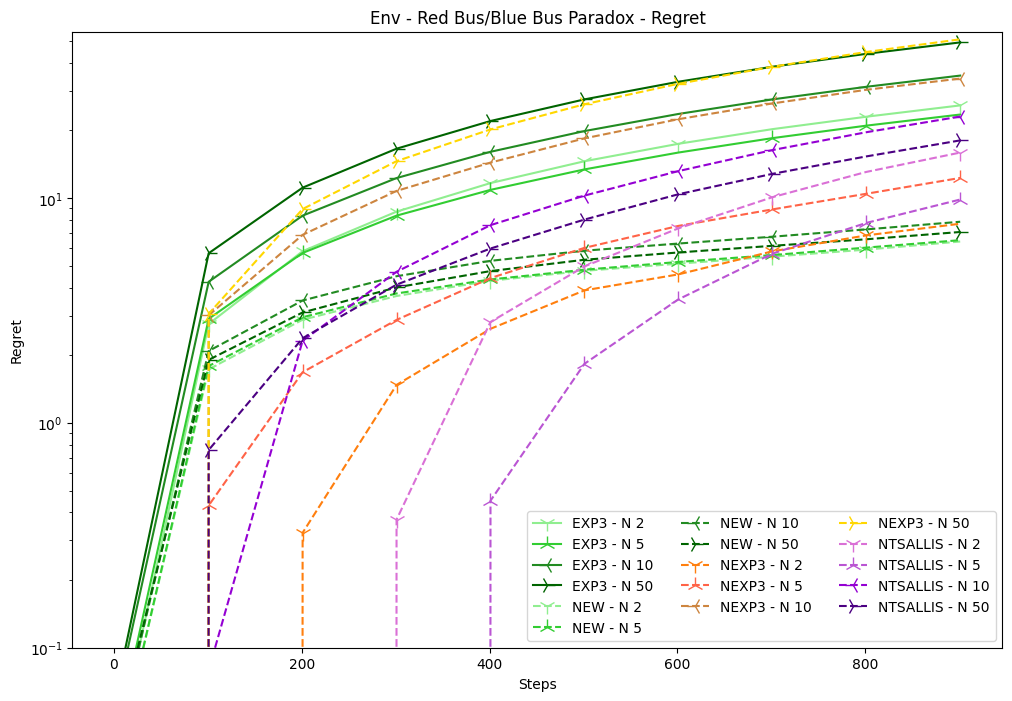

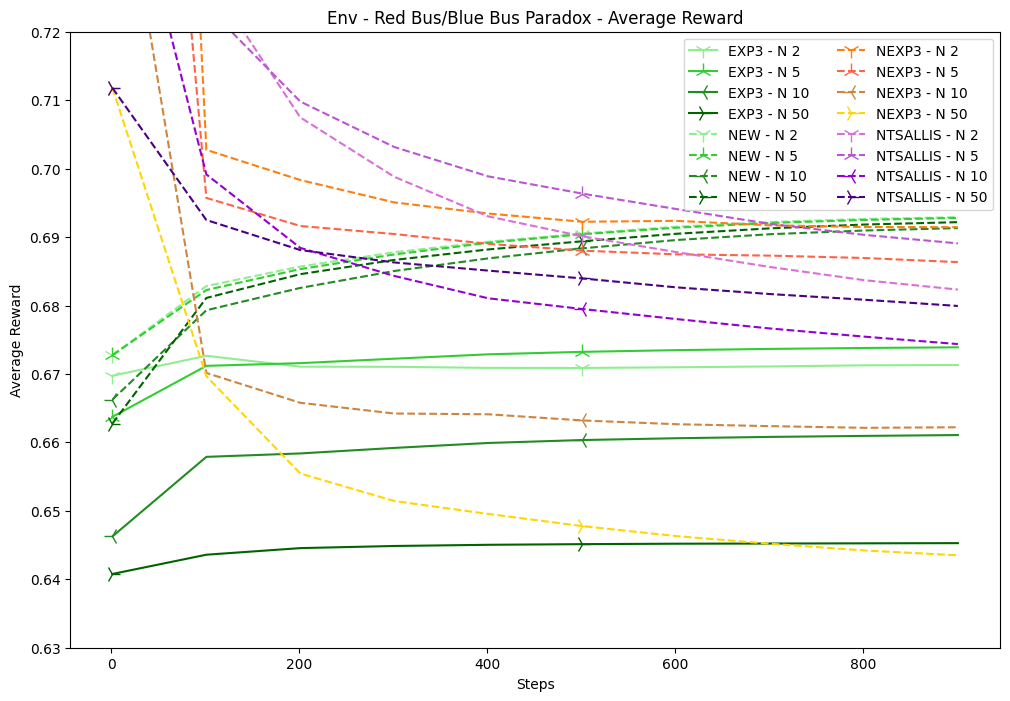

In [31]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
rounds = np.arange(1, max_rounds+1, 100)

#COLORS
colors_exp3 = ['lightsteelblue', 'cornflowerblue', 'royalblue', '#1f77b4']
colors_new = ['lightgreen', 'limegreen', 'forestgreen', 'darkgreen']
colors_nexp3 = ['#ff7f0e', 'tomato', 'peru', 'gold']
colors_ntsallis = ['orchid', 'mediumorchid', 'darkviolet', 'indigo']

#PARAMETERS
nb_childs = [2, 5, 10, 50]
markers = ["1", "2", "3", "4"]
# markers = ["*", "+", ".", "v"]

#FIGURE
plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')


#EXP3
for idx, exp3_result in enumerate(exp3_results):
    c = colors_new[idx]
    exp3_regret, exp3_rgrt_std, exp3_reward, exp3_rwd_std = exp3_result
    plt.plot(rounds, exp3_regret, label='EXP3 - N {}'.format(nb_childs[idx]), color=c, linestyle='-', 
             marker=markers[idx] , markersize=12 ,markevery=0.1)
# plt.plot(rounds, .5*rounds**(0.5), label='$t^{0.5}$', linestyle='-.')

#NEW    
for idx, new_result in enumerate(new_results):
    c = colors_new[idx]
    new_regret, new_rgrt_std, new_reward, new_rwd_std = new_result
    plt.plot(rounds, new_regret, label='NEW - N {}'.format(nb_childs[idx]), color=c, linestyle='--', 
             marker=markers[idx] , markersize=12 ,markevery=0.1)

#NEXP3    
for idx, nexp3_result in enumerate(nexp3_results):
    # new
    c = colors_nexp3[idx]
    nexp3_regret, nexp3_rgrt_std, nexp3_reward, nexp3_rwd_std = nexp3_result
    plt.plot(rounds, nexp3_regret, label='NEXP3 - N {}'.format(nb_childs[idx]), color=c, linestyle='--', 
             marker=markers[idx] , markersize=12 ,markevery=0.1)
    
#NTSALLIS    
for idx, ntsallis_result in enumerate(ntsallis_results):
    # new
    c = colors_ntsallis[idx]
    ntsallis_regret, ntsallis_rgrt_std, ntsallis_reward, ntsallis_rwd_std = ntsallis_result
    plt.plot(rounds, ntsallis_regret, label='NTSALLIS - N {}'.format(nb_childs[idx]), color=c, linestyle='--', 
             marker=markers[idx] , markersize=12 ,markevery=0.1)
# plt.plot(rounds, .05*rounds**(1), label='$t^{1}$', linestyle='-.')
plt.xlabel('Steps')
plt.ylabel('Regret')
plt.title('Env - Red Bus/Blue Bus Paradox - Regret')
#plt.xscale('log')
plt.yscale('log')
plt.ylim(0.1, 55)
# plt.xlim(1, 1000)
plt.legend(ncol=3)
plt.savefig('figure_bbrb_regret.pdf', bbox_inches = "tight")
plt.show()



plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')

for idx, exp3_result in enumerate(exp3_results):  
    # EXP3 
    c = colors_new[idx]
    exp3_regret, exp3_rgrt_std, exp3_reward, exp3_rwd_std = exp3_result
    plt.plot(rounds, exp3_reward, label='EXP3 - N {}'.format(nb_childs[idx]), color=c, linestyle='-', 
             marker=markers[idx] , markersize=12 ,markevery=5)
    
for idx, new_result in enumerate(new_results):       
    # NEW 
    c = colors_new[idx]
    new_regret, new_rgrt_std, new_reward, new_rwd_std = new_result
    plt.plot(rounds, new_reward, label='NEW - N {}'.format(nb_childs[idx]), color=c, linestyle='--', 
             marker=markers[idx] , markersize=12 ,markevery=5)
    
for idx, nexp3_result in enumerate(nexp3_results):       
    # NEXP3
    c = colors_nexp3[idx]
    nexp3_regret, nexp3_rgrt_std, nexp3_reward, nexp3_rwd_std = nexp3_result
    plt.plot(rounds, nexp3_reward, label='NEXP3 - N {}'.format(nb_childs[idx]), color=c, linestyle='--', 
             marker=markers[idx] , markersize=12 ,markevery=5)
    
for idx, ntsallis_result in enumerate(ntsallis_results):       
    # NTSALLIS
    c = colors_ntsallis[idx]
    ntsallis_regret, ntsallis_rgrt_std, ntsallis_reward, ntsallis_rwd_std = ntsallis_result
    plt.plot(rounds, ntsallis_reward, label='NTSALLIS - N {}'.format(nb_childs[idx]), color=c, linestyle='--', 
             marker=markers[idx] , markersize=12 ,markevery=5)
      
plt.xlabel('Steps')
plt.ylabel('Average Reward')
plt.title('Env - Red Bus/Blue Bus Paradox - Average Reward')
plt.legend(ncol=2)
plt.savefig('figure_bbrb_avg_reward.pdf', bbox_inches = "tight")
plt.ylim(0.63,0.72)
#plt.xscale('log')
# fig.suptitle("Env - Blue Bus Red Bus Paradox", fontsize=14)
plt.show()

In [3]:
nb_rds = 20
max_rounds = 10000

def do_general_tree_experiment(nb_levels, nb_leaves_per_class):

    exp3_regrets = np.zeros((nb_rds, int(max_rounds/100)))
    exp3_rewards = np.zeros((nb_rds, int(max_rounds/100)))
    new_regrets = np.zeros((nb_rds, int(max_rounds/100)))
    new_rewards = np.zeros((nb_rds, int(max_rounds/100)))
    nexp3_regrets = np.zeros((nb_rds, int(max_rounds/100)))
    nexp3_rewards = np.zeros((nb_rds, int(max_rounds/100)))
    ntsallis_regrets = np.zeros((nb_rds, int(max_rounds/100)))
    ntsallis_rewards = np.zeros((nb_rds, int(max_rounds/100)))
    
    for rd in range(nb_rds):
        settings = {
            'rd': rd,
            'max_rounds': max_rounds,
            'nb_leaves_per_class': nb_leaves_per_class,
            'nb_levels': nb_levels,
            'env': 'general',
            'algo': 'exp3'
        }
        
        print('Running experiment with rnd seed {}, nb levels {}, nb leaves per class {}'.format(rd, nb_levels, nb_leaves_per_class))
        
        
        metrics = do_single_experiment(rd, settings)
        rounds = metrics['round']
        exp3_regrets[rd] = metrics['regret']
        exp3_rewards[rd] = metrics['reward']
        
        settings['algo'] = 'new'
        metrics = do_single_experiment(rd, settings)
        rounds = metrics['round']
        new_regrets[rd] = metrics['regret']
        new_rewards[rd] = metrics['reward']

        settings['algo'] = 'nexp3'
        metrics = do_single_experiment(rd, settings)
        rounds = metrics['round']
        nexp3_regrets[rd] = metrics['regret']
        nexp3_rewards[rd] = metrics['reward']


        settings['algo'] = 'ntsallis'
        metrics = do_single_experiment(rd, settings)
        rounds = metrics['round']
        ntsallis_regrets[rd] = metrics['regret']
        ntsallis_rewards[rd] = metrics['reward']

    # EXP3
    exp3_rgrt_std = np.std(exp3_regrets, axis=0)
    exp3_rwd_std = np.std(exp3_rewards, axis=0)
    exp3_regret = np.mean(exp3_regrets, axis=0)
    exp3_reward = np.mean(exp3_rewards, axis=0)
    
    exp3_result = (exp3_regret, exp3_rgrt_std, exp3_reward, exp3_rwd_std)

    # new
    new_rgrt_std = np.std(new_regrets, axis=0)
    new_rwd_std = np.std(new_rewards, axis=0)
    new_regret = np.mean(new_regrets, axis=0) 
    new_reward = np.mean(new_rewards, axis=0)
    
    new_result = (new_regret, new_rgrt_std, new_reward, new_rwd_std)

    # nexp3
    nexp3_rgrt_std = np.std(nexp3_regrets, axis=0)
    nexp3_rwd_std = np.std(nexp3_rewards, axis=0)
    nexp3_regret = np.mean(nexp3_regrets, axis=0) 
    nexp3_reward = np.mean(nexp3_rewards, axis=0)
    
    nexp3_result = (nexp3_regret, nexp3_rgrt_std, nexp3_reward, nexp3_rwd_std)

    # nexp3
    ntsallis_rgrt_std = np.std(ntsallis_regrets, axis=0)
    ntsallis_rwd_std = np.std(ntsallis_rewards, axis=0)
    ntsallis_regret = np.mean(ntsallis_regrets, axis=0) 
    ntsallis_reward = np.mean(ntsallis_rewards, axis=0)
    
    ntsallis_result = (ntsallis_regret, ntsallis_rgrt_std, ntsallis_reward, ntsallis_rwd_std)
    
    return (exp3_result, new_result, nexp3_result, ntsallis_result,
            list(np.array(exp3_regrets)[:,-1]), list(np.array(new_regrets)[:,-1]), 
            list(np.array(nexp3_regrets)[:,-1]), list(np.array(ntsallis_regrets)[:,-1]))

In [ ]:
settings = [(2, 50)] #, (2, 100), (2, 200)]
res_nexp3 = []
res_new = []
res_exp3 = []
res_ntsallis = []
res=[]
labels=[]
exp3_results = []
new_results = []
nexp3_results = []
ntsallis_results = []

for setting in settings:
    nb_levels, nb_leaves_per_class = setting
    exp3_result, new_result, nexp3_result, ntsallis_result, a,b,c, d = do_general_tree_experiment(nb_levels, nb_leaves_per_class)
    exp3_results.append(exp3_result)
    new_results.append(new_result)
    nexp3_results.append(nexp3_result)
    ntsallis_results.append(ntsallis_result)
    res_exp3.append(a)
    res_new.append(b)
    res_nexp3.append(c)
    res_ntsallis.append(d)
    res.append(a)
    res.append(b)
    res.append(c)
    res.append(d)
    labels.append('EXP3 - L {}, M {}'.format(nb_levels, nb_leaves_per_class))
    labels.append('NEW - L {}, M {}'.format(nb_levels, nb_leaves_per_class))
    labels.append('NEXP3 - L {}, M {}'.format(nb_levels, nb_leaves_per_class))
    labels.append('NTSALLIS-INF - L {}, M {}'.format(nb_levels, nb_leaves_per_class))

Running experiment with rnd seed 0, nb levels 2, nb leaves per class 50


  0%|          | 0/10000 [00:00<?, ?it/s]/Users/a.cablant/Documents/GitHub/Nested-Bandits/src/algorithms/ntsallis.py:81: RuntimeWarning: divide by zero encountered in divide
  return 2 * np.sum(np.sqrt(p) - np.sqrt(q)) - np.sum((p-q)/np.sqrt(p))


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


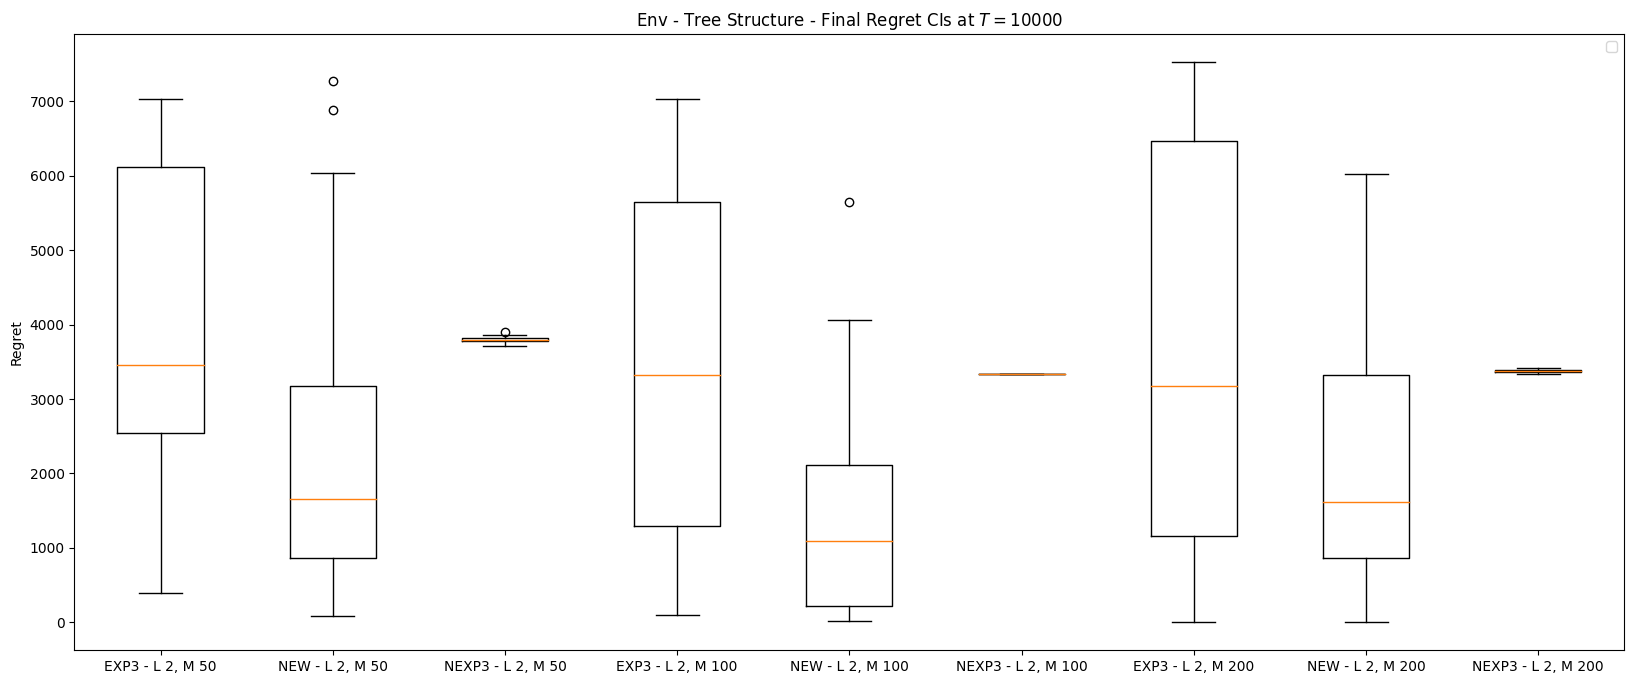

In [12]:
plt.figure(figsize=(20,8))
plt.boxplot(res, labels=labels)
plt.ylabel('Regret')
plt.title('Env - Tree Structure - Final Regret CIs at $T=10000$')
plt.legend(ncol=2)
plt.savefig('figure_general_regret_breadth_slice.pdf', bbox_inches = "tight")
plt.show()

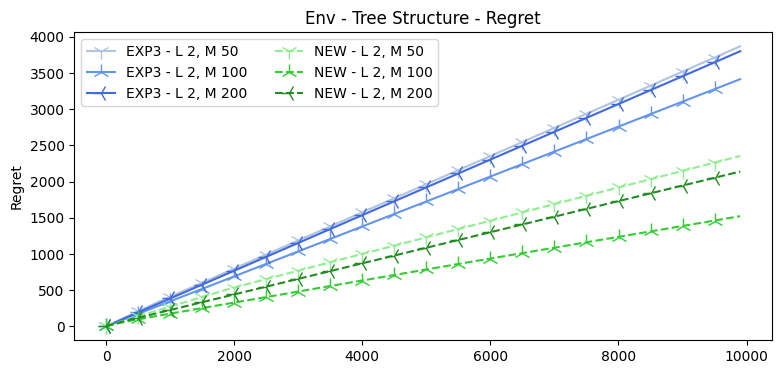

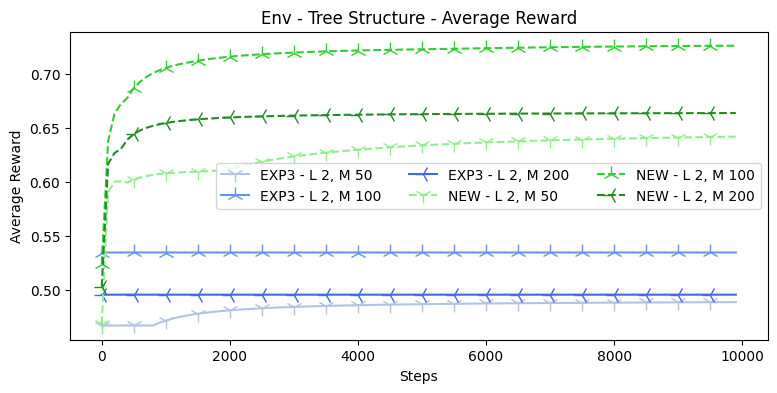

In [ ]:
rounds = np.arange(1, max_rounds+1, 100)

colors_exp3 = ['lightsteelblue', 'cornflowerblue', 'royalblue', '#1f77b4']
colors_new = ['lightgreen', 'limegreen', 'forestgreen', 'darkgreen']
colors_nexp3 = ['#ff7f0e', 'tomato', 'peru', 'gold']
# colors_new = ['#ff7f0e', 'tomato', 'peru', 'gold']
# colors_new = ['lightgreen', 'limegreen', 'forestgreen', 'darkgreen', 'darkcyan', 'darkslategrey']



settings = [(2, 50), (2, 100), (2, 200)]
markers = ['-', '--']
markers = ["1", "2", "3", "4"]
# markers = ["*", "+", ".", "v"]

plt.figure(figsize=(9,4), dpi= 100, facecolor='w', edgecolor='k')
for idx, exp3_result in enumerate(exp3_results):
    # EXP3 
    c = colors_exp3[idx]
    exp3_regret, exp3_rgrt_std, exp3_reward, exp3_rwd_std = exp3_result
    plt.plot(rounds, exp3_regret, label='EXP3 - L {}, M {}'.format(settings[idx][0], settings[idx][1]), color=c, linestyle='-',
             marker=markers[idx] , markersize=12 ,markevery=5)
# plt.plot(rounds, rounds**(0.5), label='$t^{0.5}$', ls='-.')     
for idx, new_result in enumerate(new_results[:3]):
    # new
    c = colors_new[idx]
    new_regret, new_rgrt_std, new_reward, new_rwd_std = new_result
    plt.plot(rounds, new_regret, label='NEW - L {}, M {}'.format(settings[idx][0], settings[idx][1]), color=c, linestyle='--',
             marker=markers[idx] , markersize=12 ,markevery=5)
    
for idx, nexp3_result in enumerate(nexp3_results[:3]):
    # nexp3
    c = colors_nexp3[idx]
    nexp3_regret, nexp3_rgrt_std, nexp3_reward, nexp3_rwd_std = nexp3_result
    plt.plot(rounds, nexp3_regret, label='NEXP3 - L {}, M {}'.format(settings[idx][0], settings[idx][1]), color=c, linestyle='--',
             marker=markers[idx] , markersize=12 ,markevery=5)


# plt.xscale('log')
# plt.yscale('log')
plt.ylabel('Regret')
plt.title('Env - Tree Structure - Regret')
plt.legend(ncol=2)
plt.savefig('figure_general_regret_breadth.pdf', bbox_inches = "tight")
plt.show()

plt.figure(figsize=(9,4), dpi= 100, facecolor='w', edgecolor='k')

for idx, exp3_result in enumerate(exp3_results):
    
    # EXP3 
    c = colors_exp3[idx]
    exp3_regret, exp3_rgrt_std, exp3_reward, exp3_rwd_std = exp3_result
    plt.plot(rounds, exp3_reward, label='EXP3 - L {}, M {}'.format(settings[idx][0], settings[idx][1]), color=c, linestyle='-',
             marker=markers[idx] , markersize=12 ,markevery=5)
    
for idx, new_result in enumerate(new_results):
        
    # new 
    c = colors_new[idx]
    new_regret, new_rgrt_std, new_reward, new_rwd_std = new_result
    plt.plot(rounds, new_reward, label='NEW - L {}, M {}'.format(settings[idx][0], settings[idx][1]), color=c, linestyle='--',
             marker=markers[idx] , markersize=12 ,markevery=5)
    
    
for idx, nexp3_result in enumerate(nexp3_results):
        
    # nexp3 
    c = colors_nexp3[idx]
    nexp3_regret, nexp3_rgrt_std, nexp3_reward, nexp3_rwd_std = nexp3_result
    plt.plot(rounds, nexp3_reward, label='NEXP3 - L {}, M {}'.format(settings[idx][0], settings[idx][1]), color=c, linestyle='--',
             marker=markers[idx] , markersize=12 ,markevery=5)

plt.xlabel('Steps')
plt.ylabel('Average Reward')
plt.title('Env - Tree Structure - Average Reward')
plt.legend(ncol=2)
plt.savefig('figure_general_avg_reward_breadth.pdf', bbox_inches = "tight")

# fig.suptitle("Env - Blue Bus Red Bus Paradox", fontsize=14)
plt.show()

In [ ]:
settings = [(4, 3), (5, 3), (6, 3)]
res_nexp3 = []
res_new = []
res_exp3 = []
res=[]
labels=[]
exp3_results = []
new_results = []
nexp3_results = []


for setting in tqdm(settings):
    nb_levels, nb_leaves_per_class = setting
    exp3_result, new_result, nexp3_result, a, b, c = do_general_tree_experiment(nb_levels, nb_leaves_per_class)
    exp3_results.append(exp3_result)
    new_results.append(new_result)
    nexp3_results.append(nexp3_result)
    res_exp3.append(a)
    res_new.append(b)
    res_nexp3.append(c)
    res.append(a)
    res.append(b)
    res.append(c)
    labels.append('EXP3 - L {}, M {}'.format(nb_levels, nb_leaves_per_class))
    labels.append('NEW - L {}, M {}'.format(nb_levels, nb_leaves_per_class))
    labels.append('NEXP3 - L {}, M {}'.format(nb_levels, nb_leaves_per_class))

In [ ]:
rounds = np.arange(1, max_rounds+1, 100)

#COLORS
colors_exp3 = ['lightsteelblue', 'cornflowerblue', 'royalblue', '#1f77b4']
colors_new = ['lightgreen', 'limegreen', 'forestgreen', 'darkgreen']
colors_nexp3 = ['#ff7f0e', 'tomato', 'peru', 'gold']

#PARAMETERS
settings = [(4, 3), (5, 3), (6, 3)]
markers = ['-', '--']
markers = ["1", "2", "3", "4"]


plt.figure(figsize=(9,4), dpi= 100, facecolor='w', edgecolor='k')
for idx, exp3_result in enumerate(exp3_results):
    # EXP3 
    c = colors_exp3[idx]
    exp3_regret, exp3_rgrt_std, exp3_reward, exp3_rwd_std = exp3_result
    plt.plot(rounds, exp3_regret, label='EXP3 - L {}, M {}'.format(settings[idx][0], settings[idx][1]), color=c, linestyle='-', 
             marker=markers[idx] , markersize=12 ,markevery=5)
# plt.plot(rounds, .5*rounds**(0.5), label='$t^{0.5}$', linestyle='-.')    
for idx, new_result in enumerate(new_results[:3]):
    # new
    c = colors_exp3[idx]
    new_regret, new_rgrt_std, new_reward, new_rwd_std = new_result
    plt.plot(rounds, new_regret, label='NEW - L {}, M {}'.format(settings[idx][0], settings[idx][1]), color=c, linestyle='--', 
             marker=markers[idx] , markersize=12 ,markevery=5)
    
for idx, new_result in enumerate(nexp3_results[:3]):
    # nexp3
    c = colors_nexp3[idx]
    nexp3_regret, nexp3_rgrt_std, nexp3_reward, nexp3_rwd_std = nexp3_result
    plt.plot(rounds, nexp3_regret, label='NEW - L {}, M {}'.format(settings[idx][0], settings[idx][1]), color=c, linestyle='--', 
             marker=markers[idx] , markersize=12 ,markevery=5)

# plt.xscale('log')
# plt.yscale('log')
plt.ylabel('Regret')
plt.title('Env - Tree Structure - Regret')
plt.legend(ncol=2)
plt.savefig('figure_general_regret_depth.pdf', bbox_inches = "tight")
plt.show()

plt.figure(figsize=(9,4), dpi= 100, facecolor='w', edgecolor='k')

for idx, exp3_result in enumerate(exp3_results):
    
    # EXP3 
    c = colors_exp3[idx]
    exp3_regret, exp3_rgrt_std, exp3_reward, exp3_rwd_std = exp3_result
    plt.plot(rounds, exp3_reward, label='EXP3 - L {}, M {}'.format(settings[idx][0], settings[idx][1]), color=c, linestyle='-',
             marker=markers[idx] , markersize=12 ,markevery=5)
    
for idx, new_result in enumerate(new_results):
        
    # new 
    c = colors_exp3[idx]
    new_regret, new_rgrt_std, new_reward, new_rwd_std = new_result
    plt.plot(rounds, new_reward, label='NEW - L {}, M {}'.format(settings[idx][0], settings[idx][1]), color=c, linestyle='--',
             marker=markers[idx] , markersize=12 ,markevery=5)
    
    # nexp3 
    c = colors_nexp3[idx]
    nexp3_regret, nexp3_rgrt_std, nexp3_reward, nexp3_rwd_std = nexp3_result
    plt.plot(rounds, nexp3_reward, label='NEXP3 - L {}, M {}'.format(settings[idx][0], settings[idx][1]), color=c, linestyle='--',
             marker=markers[idx] , markersize=12 ,markevery=5)
      
plt.xlabel('Steps')
plt.ylabel('Average Reward')
plt.title('Env - Tree Structure - Average Reward')
plt.legend(ncol=3)
plt.savefig('figure_general_avg_reward_depth.pdf', bbox_inches = "tight")

# fig.suptitle("Env - Blue Bus Red Bus Paradox", fontsize=14)
plt.show()

In [ ]:
settings = [(1, 5), (1, 10), (1, 50)]
exp3_results = []
new_results = []
nexp3_results = []
res=[]
labels=[]


for setting in tqdm(settings):
    nb_levels, nb_leaves_per_class = setting
    exp3_result, new_result, nexp3_result, a, b, c = do_general_tree_experiment(nb_levels, nb_leaves_per_class)
    exp3_results.append(exp3_result)
    new_results.append(new_result)
    nexp3_results.append(new_result)
    res_exp3.append(a)
    res_new.append(b)
    res_nexp3.append(c)
    res.append(a)
    res.append(b)
    res.append(c)
    labels.append('EXP3 - L {}, M {}'.format(nb_levels, nb_leaves_per_class))
    labels.append('NEW - L {}, M {}'.format(nb_levels, nb_leaves_per_class))
    labels.append('NEXP3 - L {}, M {}'.format(nb_levels, nb_leaves_per_class))

In [ ]:
rounds = np.arange(1, max_rounds+1, 100)

#COLORS
colors_exp3 = ['lightsteelblue', 'cornflowerblue', 'royalblue', '#1f77b4']
colors_new = ['lightgreen', 'limegreen', 'forestgreen', 'darkgreen']
colors_nexp3 = ['#ff7f0e', 'tomato', 'peru', 'gold']

# settings = [(5, 3), (6, 3), (7, 3)]
markers = ['-', '--']
markers = ["1", "2", "3", "4"]


plt.figure(figsize=(9,4), dpi= 100, facecolor='w', edgecolor='k')
for idx, exp3_result in enumerate(exp3_results):
    # EXP3 
    c = colors_exp3[idx]
    exp3_regret, exp3_rgrt_std, exp3_reward, exp3_rwd_std = exp3_result
    plt.plot(rounds, exp3_regret, label='EXP3 - L {}, M {}'.format(settings[idx][0], settings[idx][1]), color=c, linestyle='-', 
             marker=markers[idx] , markersize=12 ,markevery=5)
# plt.plot(rounds, .5*rounds**(0.5), label='$t^{0.5}$', linestyle='-.')    
for idx, new_result in enumerate(new_results[:3]):
    # new
    c = colors_exp3[idx]
    new_regret, new_rgrt_std, new_reward, new_rwd_std = new_result
    plt.plot(rounds, new_regret, label='NEW - L {}, M {}'.format(settings[idx][0], settings[idx][1]), color=c, linestyle='--', 
             marker=markers[idx] , markersize=12 ,markevery=5)
    
for idx, nexp3_result in enumerate(nexp3_results[:3]):
    # nexp3
    c = colors_nexp3[idx]
    nexp3_regret, nexp3_rgrt_std, nexp3_reward, nexp3_rwd_std = nexp3_result
    plt.plot(rounds, nexp3_regret, label='NEXP3 - L {}, M {}'.format(settings[idx][0], settings[idx][1]), color=c, linestyle='--', 
             marker=markers[idx] , markersize=12 ,markevery=5)

# plt.xscale('log')
# plt.yscale('log')
plt.ylabel('Regret')
plt.title('Env - Tree Structure - Regret')
plt.legend(ncol=2)
plt.savefig('figure_general_regret_depth2.pdf', bbox_inches = "tight")
plt.show()

plt.figure(figsize=(9,4), dpi= 100, facecolor='w', edgecolor='k')

for idx, exp3_result in enumerate(exp3_results):
    
    # EXP3 
    c = colors_exp3[idx]
    exp3_regret, exp3_rgrt_std, exp3_reward, exp3_rwd_std = exp3_result
    plt.plot(rounds, exp3_reward, label='EXP3 - L {}, M {}'.format(settings[idx][0], settings[idx][1]), color=c, linestyle='-',
             marker=markers[idx] , markersize=12 ,markevery=5)
    
for idx, new_result in enumerate(new_results):
        
    # new 
    c = colors_exp3[idx]
    new_regret, new_rgrt_std, new_reward, new_rwd_std = new_result
    plt.plot(rounds, new_reward, label='NEW - L {}, M {}'.format(settings[idx][0], settings[idx][1]), color=c, linestyle='--',
             marker=markers[idx] , markersize=12 ,markevery=5)
    
for idx, nexp3_result in enumerate(nexp3_results):
        
    # nexp3
    c = colors_exp3[idx]
    nexp3_regret, nexp3_rgrt_std, nexp3_reward, nexp3_rwd_std = nexp3_result
    plt.plot(rounds, new_reward, label='NEXP3 - L {}, M {}'.format(settings[idx][0], settings[idx][1]), color=c, linestyle='--',
             marker=markers[idx] , markersize=12 ,markevery=5)
      
plt.xlabel('Steps')
plt.ylabel('Average Reward')
plt.title('Env - Tree Structure - Average Reward')
plt.legend(ncol=3)
plt.savefig('figure_general_avg_reward_depth2.pdf', bbox_inches = "tight")

# fig.suptitle("Env - Blue Bus Red Bus Paradox", fontsize=14)
plt.show()